In [103]:
# Imports
import collections
import copy
import math
import numpy as np
import scipy.signal

from contextlib import suppress
from math import e, log, pi, sqrt
from numpy import sin, cos
from matplotlib import pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from PGM import PGMImage

adjust = lambda pixels: fftshift(np.log(np.abs(pixels)))

def center(spectrum: np.ndarray):
    for (i, j) in np.ndindex(spectrum.shape):
        spectrum[i][j] *= (-1 ** (i + j))

is_power_of_two = lambda x: bool((x & (x - 1)) == 0)

next_power_of_two = lambda x: 1 if x == 0 else 2 ** math.ceil(math.log2(x))

def see_spectrum(H: np.ndarray, fig=plt):
    fig.imshow(np.abs(H), cmap='gray')

def see_image(f: np.ndarray, fig=plt, clip=False):
    # Fail if there are non-negligible parasitic imaginary components in
    # the spatial domain
    # assert all(pxl.imag <= 1e-5 for pxl in np.nditer(f))
    with suppress(np.ComplexWarning):
        fig.imshow(f.astype(float), cmap='gray')

In [64]:
# Experiment 2 - Compare Spatial & Frequency Filtering
def padding_dims(spatial_kernel, img):
    M, N = img.pixels.shape
    S, T = spatial_kernel.shape
    
    # Avoid wrap-around error
    P = M + S - 1
    Q = N + T - 1
    
    # FFT only works when dimensions are 2 ** n for n in Z
    if not is_power_of_two(P):
        P = next_power_of_two(P)
    
    if not is_power_of_two(Q):
        Q = next_power_of_two(Q)
    
    return P, Q


img = PGMImage('lenna.pgm')
sobel_kernel_x = np.matrix([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_kernel_y = np.matrix([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

P, Q = padding_dims(sobel_kernel_x, img)

print(f"Padded image dimensions: P={P}, Q={Q}")

def pad_image(img, P, Q):
    M, N = img.pixels.shape
    padded_pixels = np.zeros((P, Q))
    padded_pixels[0:M, 0:N] = img.pixels
    img.pixels = padded_pixels

    
pad_image(img, P, Q)


def padded_spatial_filter(spatial_kernel, P, Q):
    S, T = spatial_kernel.shape

    # Check if the kernel itself needs to be padded with zeros
    # (required for odd functions)
    if spatial_kernel[0].any() or spatial_kernel[:,0].any():
        # Prepend a row of zeros
        spatial_kernel = np.vstack((np.zeros(T), spatial_kernel))
        S += 1
        
        # Prepend a column of zeros
        spatial_kernel = np.hstack((np.zeros((S, 1)), spatial_kernel))
        T += 1
    
    # Create an image-sized filter
    padded_spatial_filter = np.zeros((P, Q))
    
    # Find coordinates in larger filter for emplacement
    y_0 = int(P/2 - 2)
    y_1 = y_0 + S
    x_0 = int(Q/2 - 2)
    x_1 = x_0 + T
    
    # Emplace the spatial kernel into an image-sized filter
    padded_spatial_filter[y_0:y_1, x_0:x_1] = spatial_kernel
    
    return padded_spatial_filter


h_x = padded_spatial_filter(sobel_kernel_x, P, Q)
h_y = padded_spatial_filter(sobel_kernel_y, P, Q)


for h in (h_x, h_y):
    # Double-check symmetry
    S, T = h.shape
    for (i, j) in np.ndindex(h.shape):
        try:
            assert(h[i][j] == -h[S-i][T-j])
        except AssertionError:
            print(f"h[{i}][{j}] = {h[i][j]} \t\t -h[{S-i}][{T-j}] = {-h[S-i][T-j]}")
        except IndexError:
            pass

# Take FT and verify that all values are purely imaginary
H_x, H_y = fft2(h_x), fft2(h_y)

for H in (H_x, H_y):    
    for (i, j) in np.ndindex(H.shape):
        try:
            assert(H[i][j].real <= 1e-15)
            H[i][j] = complex(real=0, imag=H[i][j].imag)
        except AssertionError:
            print(f"Found non-zero value in padded odd kernel: ", i, j, H[i][j])

F = fft2(img.pixels)
g_x = ifft2( H_x * F )
g_y = ifft2( H_y * F )

Padded image dimensions: P=512, Q=512


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5, 1.0, 'Frequency Sobel Convolution (y-direction)')

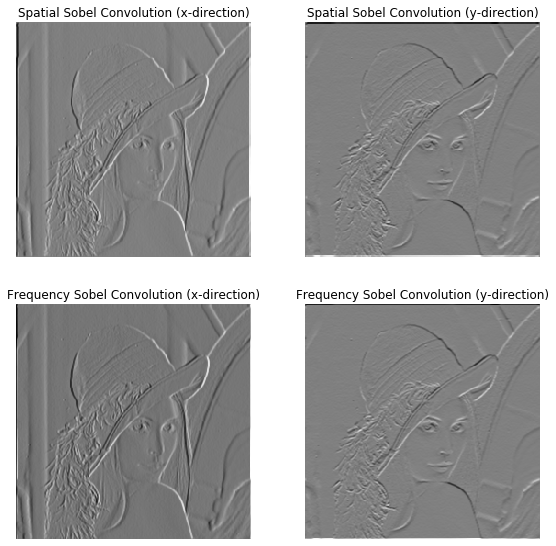

In [79]:
# Experiment 2 - Display Results
f, axarr = plt.subplots(2,2, figsize=(9.5,9.5))

# Show spatial domain convolution with Sobel masks
orig_image = PGMImage('lenna.pgm')

axarr[0, 0].imshow(scipy.signal.convolve2d(orig_image.pixels, sobel_kernel_x), cmap='gray')
axarr[0, 0].axis('off')
axarr[0, 0].set_title("Spatial Sobel Convolution (x-direction)")

axarr[0, 1].imshow(scipy.signal.convolve2d(orig_image.pixels, sobel_kernel_y), cmap='gray')
axarr[0, 1].axis('off')
axarr[0, 1].set_title("Spatial Sobel Convolution (y-direction)")

# Show frequency domain convolution with Sobel masks

# Convolution flips the axis of original image, and we padded with zeros
# So, extract the image from the bottom right corner of conv. output
rows, cols = orig_image.pixels.shape

see_image(g_x[-rows:, -cols:], axarr[1, 0])
axarr[1, 0].axis('off')
axarr[1, 0].set_title("Frequency Sobel Convolution (x-direction)")

see_image(g_y[-rows:, -cols:], axarr[1, 1])
axarr[1, 1].axis('off')
axarr[1, 1].set_title("Frequency Sobel Convolution (y-direction)")

Running experiment γL = 0.0 γH = 1.0


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


Running experiment γL = 0.0 γH = 1.5
Running experiment γL = 0.0 γH = 2.0
Running experiment γL = 0.5 γH = 1.0
Running experiment γL = 0.5 γH = 1.5
Running experiment γL = 0.5 γH = 2.0
Running experiment γL = 1.0 γH = 1.0
Running experiment γL = 1.0 γH = 1.5
Running experiment γL = 1.0 γH = 2.0


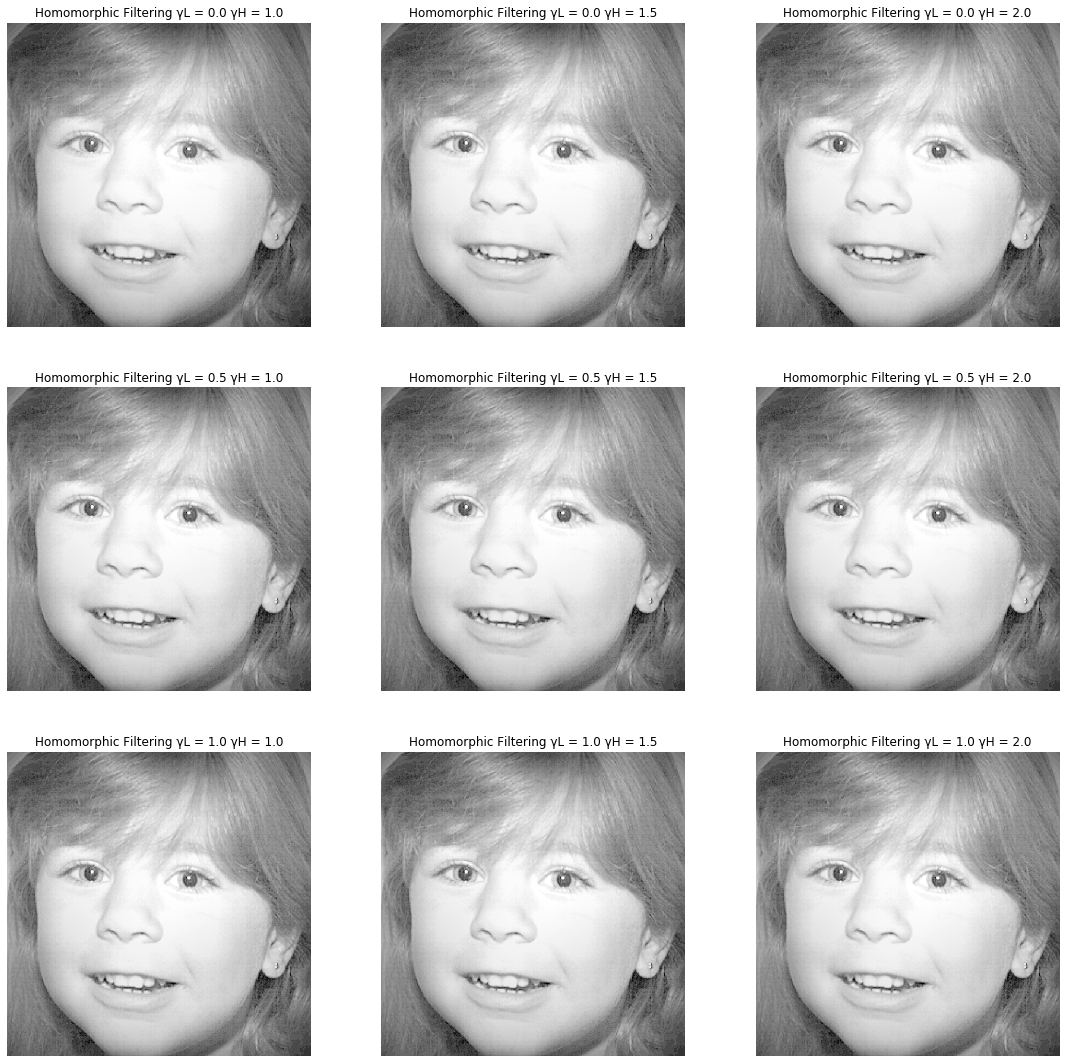

In [117]:
# Experiment 4
p = PGMImage('girl.pgm')
f = p.pixels

# Step 1. Take ln of image
f = np.log1p(f)

# Step 2. Take FT of image
Z = fft2(f)

# Step 3. Apply high-pass filtering
D_0 = 1.8
c = 1

f, axarr = plt.subplots(3, 3, figsize=(19, 19))
results = np.ndarray((3, 3))

for x in range(0, 3):
    for y in range(0, 3):
        Y_l = x / 2
        Y_h = (y / 2) + 1
        print(f"Running experiment γL = {Y_l} γH = {Y_h}")

        def HFE(u, v, Y_h, Y_l):
            return (
                (Y_h - Y_l) * (1 - e ** (-c * (u**2 + v**2)/(D_0**2) ) )
            ) + Y_l
        
        # Define a new high-frequency emphasis filter based on experimental parameters
        for (i, j) in np.ndindex(F.shape):
            Z[i][j] *= HFE(i, j, Y_h, Y_l)
                
        # Step 4. Take the Inverse Fourier Transform of the image from step 3.
        s = ifft2(Z)

        # Step 5. Apply the exponential function on the image from step 4.
        g = np.log(e ** s)
        
        # Step 6. Display the magnitude of the image from step 5.
        see_image(g, axarr[x, y])
        axarr[x, y].axis('off')
        axarr[x, y].set_title(f"Homomorphic Filtering γL = {Y_l:.1f} γH = {Y_h:.1f}")